In [1]:
from helpers.sequence_slider import SequenceSlider
from helpers.config import load_config
from helpers.logger import logger


from scripts.data_transformation import DataTransformation
from scripts.data_ingestion import DataIngestion

import pandas as pd
import numpy as  np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

from src.models.bi_lstm import BiLSTM

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score,root_mean_squared_error,mean_squared_error,mean_absolute_percentage_error,mean_absolute_error

import matplotlib.pyplot as plt


config = load_config()
window_size = 7
obj = SequenceSlider(window_size)

train_scaled,test_scaled = DataTransformation(config).transform()

X_train,y_train,X_test,y_test = obj.transform(train=train_scaled,test=test_scaled)




2025-12-07 10:56:43 - INFO - helpers.logger - 44 - shape of training data: (857, 1)
2025-12-07 10:56:43 - INFO - helpers.logger - 53 - Length of training data: 685
2025-12-07 10:56:43 - INFO - helpers.logger - 54 - Length of testing data: 172
2025-12-07 10:56:43 - INFO - helpers.logger - 73 - Shape of training data scaled: (685, 1)
2025-12-07 10:56:43 - INFO - helpers.logger - 74 - Shape of testing data scaled: (172, 1)


In [2]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

(torch.Size([678, 7, 1]),
 torch.Size([165, 7, 1]),
 torch.Size([678, 1]),
 torch.Size([165, 1]))

In [3]:
# Bi-Directional LSTM

model = BiLSTM()
learning_rate = 0.001
epochs = 200
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
criterion = nn.MSELoss()





In [4]:
for epoch in range(epochs):
    model.train()
    y_pred = model(X_train)
    loss = criterion(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    with torch.no_grad():
        model.eval()
        y_pred = model(X_train)
        train_rmse = np.sqrt(criterion(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rmse = np.sqrt(criterion(y_pred_test,y_test))
        print(f"Epoch: {epoch}: Train_RMSE: {train_rmse:.4};TestRMSE: {test_rmse:.4};")

/tmp/ipykernel_19708/3270720142.py:11: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(criterion(y_pred,y_train))
/tmp/ipykernel_19708/3270720142.py:13: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(criterion(y_pred_test,y_test))


Epoch: 0: Train_RMSE: 0.226;TestRMSE: 0.1115;
Epoch: 1: Train_RMSE: 0.181;TestRMSE: 0.2652;
Epoch: 2: Train_RMSE: 0.2136;TestRMSE: 0.3295;
Epoch: 3: Train_RMSE: 0.1739;TestRMSE: 0.2559;
Epoch: 4: Train_RMSE: 0.1639;TestRMSE: 0.1881;
Epoch: 5: Train_RMSE: 0.172;TestRMSE: 0.1498;
Epoch: 6: Train_RMSE: 0.1751;TestRMSE: 0.135;
Epoch: 7: Train_RMSE: 0.1685;TestRMSE: 0.1352;
Epoch: 8: Train_RMSE: 0.1552;TestRMSE: 0.1466;
Epoch: 9: Train_RMSE: 0.1415;TestRMSE: 0.1674;
Epoch: 10: Train_RMSE: 0.1364;TestRMSE: 0.1935;
Epoch: 11: Train_RMSE: 0.1407;TestRMSE: 0.2123;
Epoch: 12: Train_RMSE: 0.1367;TestRMSE: 0.2062;
Epoch: 13: Train_RMSE: 0.1185;TestRMSE: 0.1755;
Epoch: 14: Train_RMSE: 0.1011;TestRMSE: 0.1333;
Epoch: 15: Train_RMSE: 0.0957;TestRMSE: 0.09261;
Epoch: 16: Train_RMSE: 0.09343;TestRMSE: 0.06256;
Epoch: 17: Train_RMSE: 0.07822;TestRMSE: 0.04485;
Epoch: 18: Train_RMSE: 0.05556;TestRMSE: 0.03475;
Epoch: 19: Train_RMSE: 0.08332;TestRMSE: 0.03248;
Epoch: 20: Train_RMSE: 0.07852;TestRMSE: 0.02

- Use MinMaxScaler to undue scaler on data.

In [5]:
# load in DataIngestion


data = DataIngestion(config).fetch_fred_data()



# use training to have MinMaxScaler to be fitted on.
training = data.iloc[:, 0:1].values


In [6]:
train_length = int(len(training)*0.80)

train_length


685

In [7]:
# load int MinMaxScaler and use torch.no_grad() to undue scaler for predictions.


# instance of MaxMaxScaler
scaler = MinMaxScaler()

# fit instance of MinMaxScaler on training data
scaler.fit(training)


# torch remove scaler from y_pred and y_test

with torch.no_grad():
    y_pred = model(X_test)
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(y_pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)





In [8]:
# r2-score
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f"R2 Score: {r2*100:.2f}")

# mean-square error
mse = mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Mean Squared Error: {mse:.4}")

# Root Mean-Squared Error
rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
print(f"Root Mean-Squared Error: {rmse:.4}")

# mean absolute percentage error
mape = mean_absolute_percentage_error(actual_rescaled,pred_rescaled)
print(f"Mean Absolute Percentage Error: {mape:.4f}")


# mean absolute error
mae = mean_absolute_error(actual_rescaled,pred_rescaled)
print(f"Mean Absolute Error: {mae}")

R2 Score: 99.19
Mean Squared Error: 0.02812
Root Mean-Squared Error: 0.1677
Mean Absolute Percentage Error: 0.3562
Mean Absolute Error: 0.08745470643043518


In [9]:
# comparison of Actual Fed Funds Rate to Predicted

test_dates = data.iloc[train_length + window_size:]['date']

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Fed Funds Rate": actual_rescaled.flatten(),
    "Predicted Fed Funds Rate":pred_rescaled.flatten()
})



print(f"First Ten Dates: {comparison_df.head(20)}")
print(f"Last Ten Dates: {comparison_df.tail(20)}")


First Ten Dates:           Date  Actual Fed Funds Rate  Predicted Fed Funds Rate
692 2012-03-01               0.110063                  0.057684
693 2012-04-01               0.120074                  0.087483
694 2012-05-01               0.140095                  0.103746
695 2012-06-01               0.140095                  0.123031
696 2012-07-01               0.140095                  0.126576
697 2012-08-01               0.110063                  0.125712
698 2012-09-01               0.120074                  0.099807
699 2012-10-01               0.140095                  0.099596
700 2012-11-01               0.140095                  0.116366
701 2012-12-01               0.140095                  0.122538
702 2013-01-01               0.120074                  0.124325
703 2013-02-01               0.130084                  0.107741
704 2013-03-01               0.120074                  0.110127
705 2013-04-01               0.130084                  0.103075
706 2013-05-01         

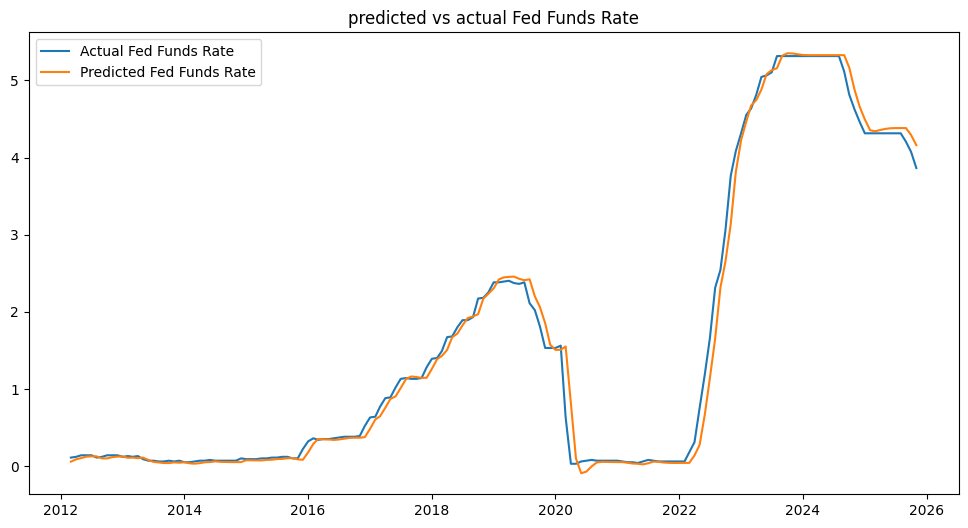

In [10]:


plt.figure(figsize=(12,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Fed Funds Rate"],label="Actual Fed Funds Rate")
plt.plot(comparison_df['Date'],comparison_df['Predicted Fed Funds Rate'],label="Predicted Fed Funds Rate")
plt.title("predicted vs actual Fed Funds Rate")
plt.savefig("images/lstm-forecast.png")
plt.legend()
plt.show()